In [61]:
import pandas as pd 
import numpy as np 
import os, shutil
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm 
import tensorflow as tf 
import keras
from keras.preprocessing.text import Tokenizer

Currently, it is important that drugs that show indication of failure in clinical trials be vetted before. This is because clinical trials take a large amount of time, patient commitment, and money; thus, finding new drugs, in the latent drug space that have clinical potential, is important.

In [5]:
# Loading dataset
# Note that this dataset contains 22,751 protein drug-like molecules 
path = "../wip_chem/chembl.csv"
chembl = pd.read_csv(path, delimiter= ';')
chembl.columns = chembl.columns.str.lower().str.replace(" ", "_")
chembl.head()

,chembl_id,name,synonyms,type,max_phase,molecular_weight,targets,bioactivities,alogp,polar_surface_area,...,heavy_atoms,hba_(lipinski),hbd_(lipinski),#ro5_violations_(lipinski),molecular_weight_(monoisotopic),np_likeness_score,molecular_species,molecular_formula,smiles,inchi_key
0,CHEMBL1201641,INSULIN ZINC SUSP EXTENDED RECOMBINANT HUMAN,HUMULIN U|INSULIN ZINC SUSP EXTENDED RECOMBINA...,Protein,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CHEMBL386120,NaN,NaN,Protein,NaN,1047.28,2.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1046.5814,NaN,NaN,C54H74N14O8,CCCC[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](Cc1c...,USRUQIUGZKUBSE-ZSXJDPQMSA-N
2,CHEMBL2107984,PEGALDESLEUKIN,PEGALDESLEUKIN,Protein,-1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CHEMBL3238082,NaN,NaN,Protein,NaN,1427.76,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1426.5542,NaN,NaN,C63H90N14O16S4,CCCC[C@@H]1NC(=O)[C@H](CO)NC(=O)[C@@H]2CSSC[C@...,QWLMGMUSVNPXPA-GOVHZBJUSA-N
4,CHEMBL1253405,NaN,NaN,Protein,NaN,2408.57,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2407.1081,NaN,NaN,C107H154N28O36,CC[C@H](C)[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H...,AFKQKYDXLSEPHU-NSQZWSSQSA-N


In [26]:
print(chembl.columns.tolist())
print(chembl.shape)

['chembl_id', 'name', 'synonyms', 'type', 'max_phase', 'molecular_weight', 'targets', 'bioactivities', 'alogp', 'polar_surface_area', 'hba', 'hbd', '#ro5_violations', '#rotatable_bonds', 'passes_ro3', 'qed_weighted', 'cx_acidic_pka', 'cx_basic_pka', 'cx_logp', 'cx_logd', 'aromatic_rings', 'structure_type', 'inorganic_flag', 'heavy_atoms', 'hba_(lipinski)', 'hbd_(lipinski)', '#ro5_violations_(lipinski)', 'molecular_weight_(monoisotopic)', 'np_likeness_score', 'molecular_species', 'molecular_formula', 'smiles', 'inchi_key']
(22751, 33)


/var/folders/m7/gj3w__8s6yz14htr_wj0h2800000gn/T/ipykernel_60068/2397443063.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("OrRd")


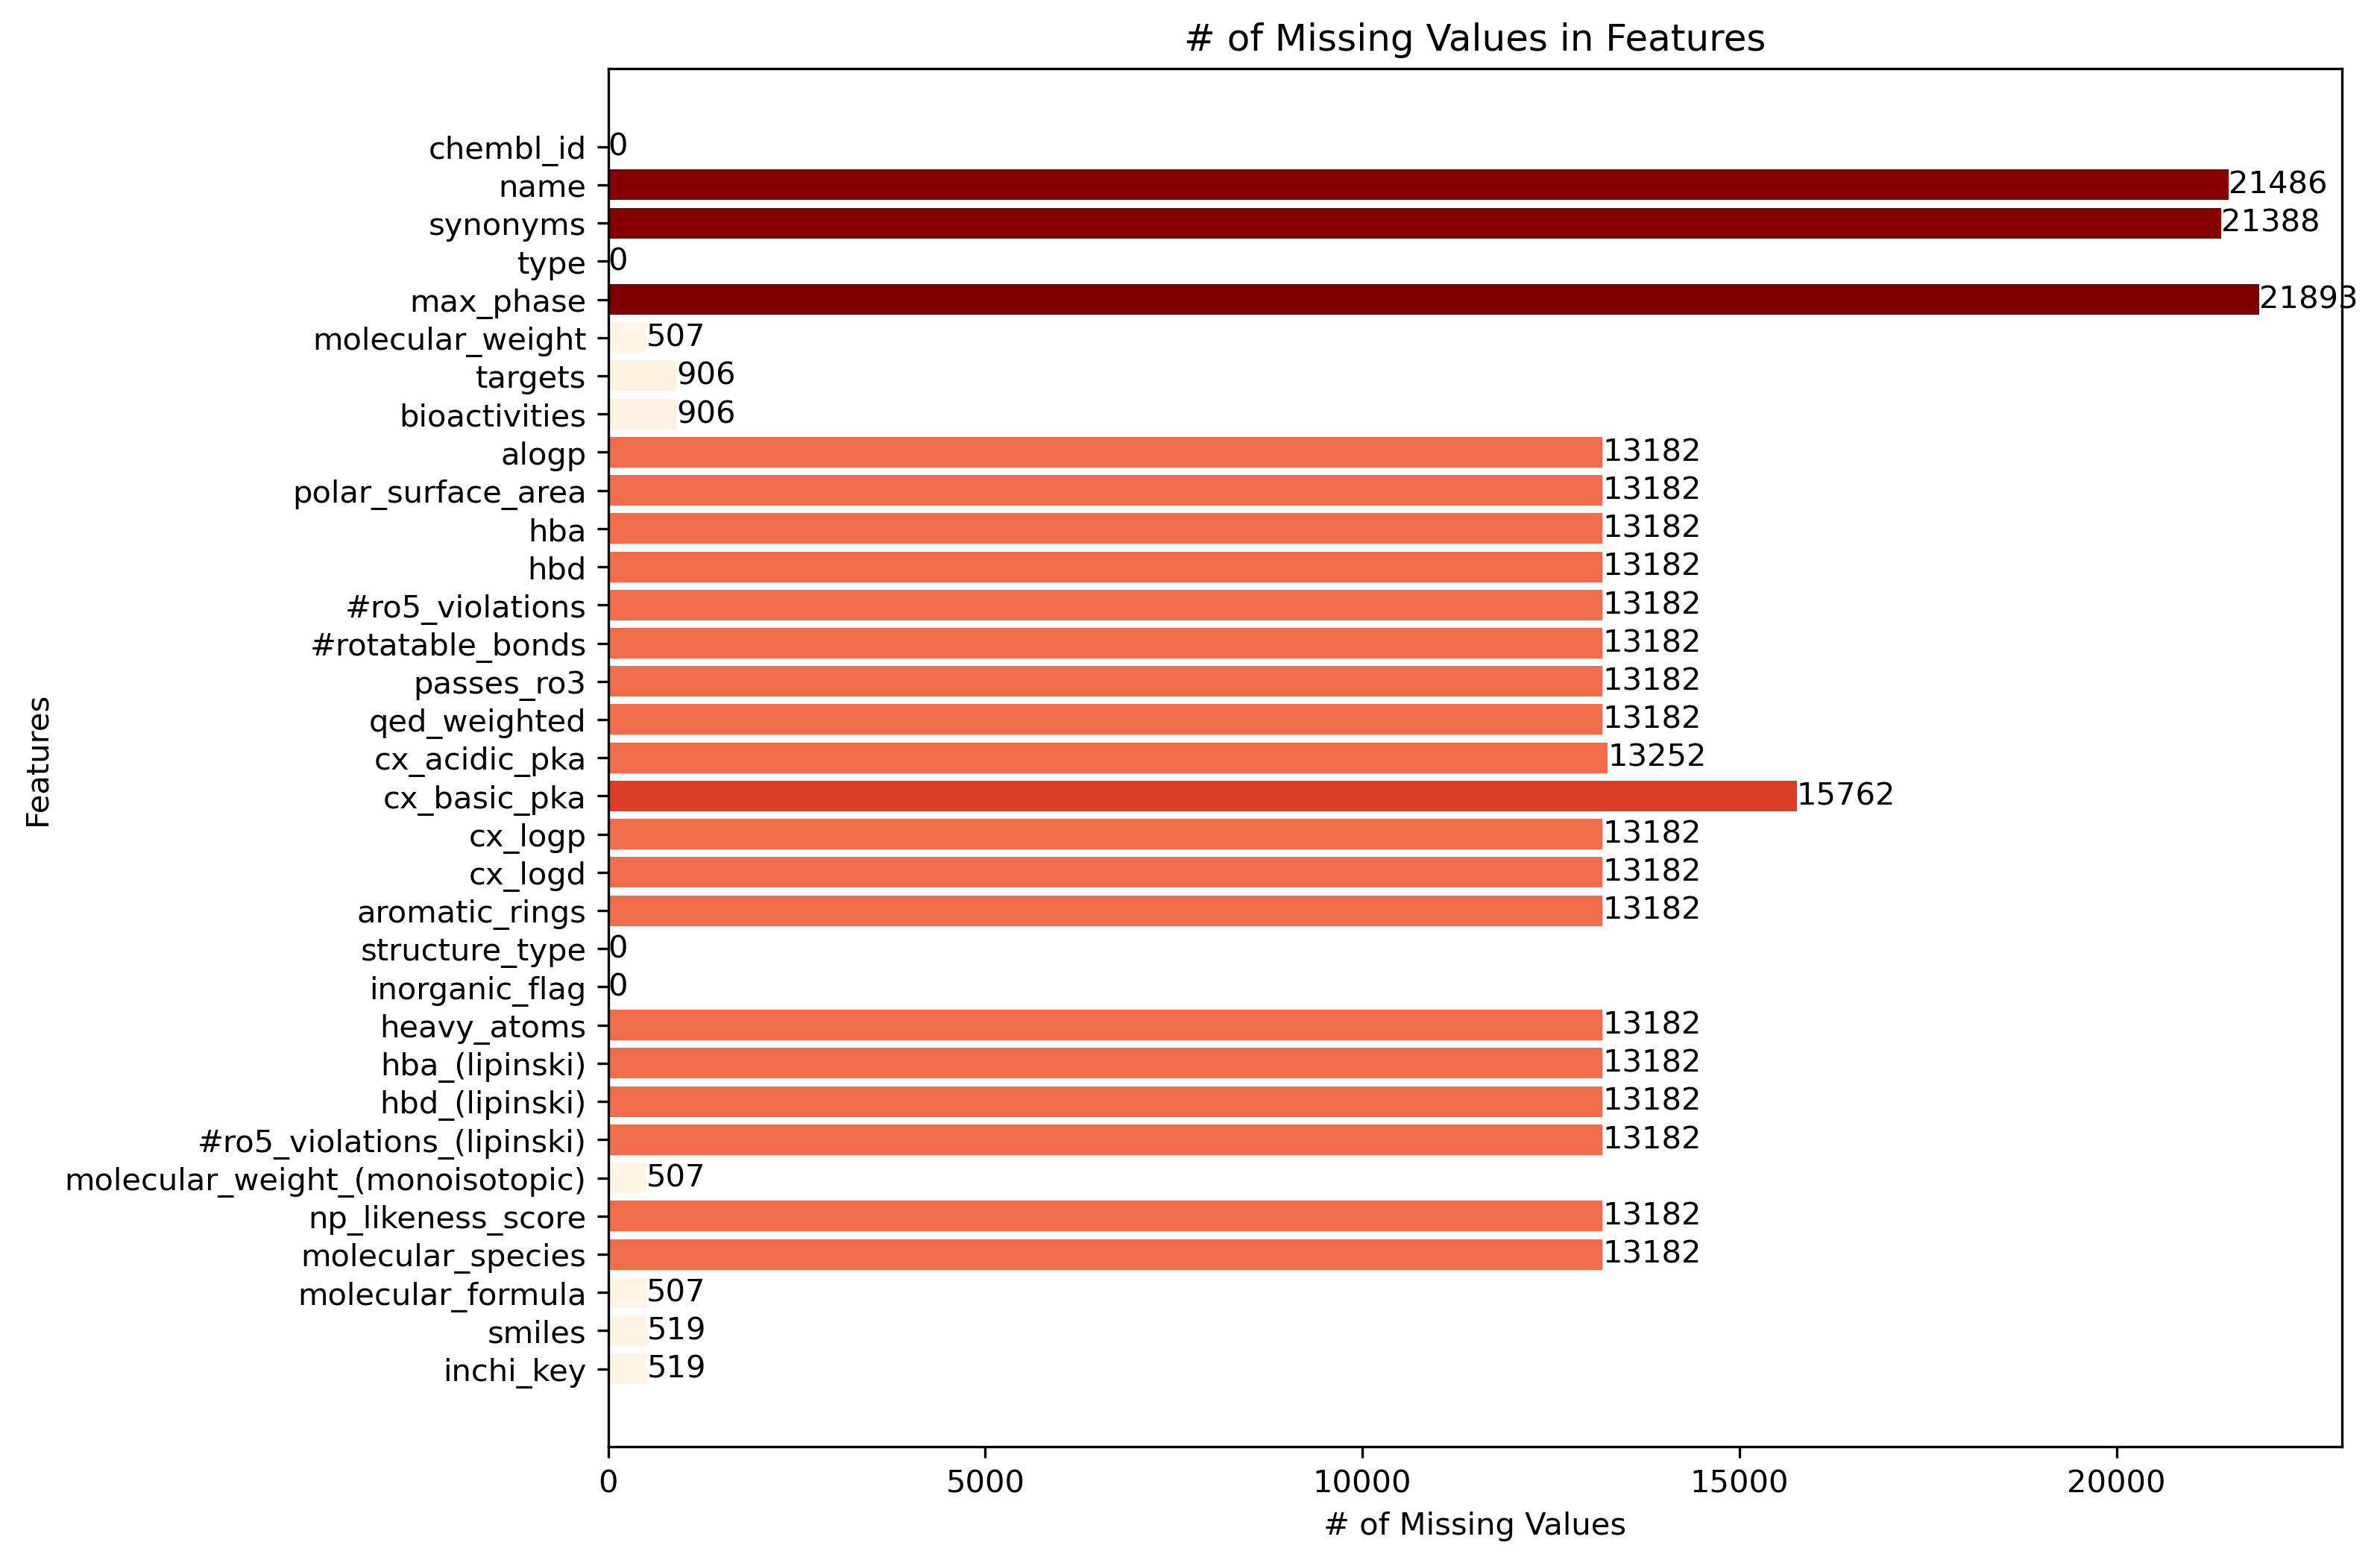

In [4]:
# Count number of missing in each column 
missing_values = chembl.isnull().sum()

# Style
plt.style.use("default")
plt.figure(figsize=(10, 8), dpi=300)

# Normalize the missing values to range [0, 1]
normalized_missing_values = missing_values / max(missing_values)
cmap = plt.cm.get_cmap("OrRd")
colors = cmap(normalized_missing_values)

# Plotting
null_val_bar = plt.barh(chembl.columns[::-1], missing_values[::-1], color = colors[::-1])

# Title and Labels 
plt.title('# of Missing Values in Features')
plt.bar_label(null_val_bar)
plt.ylabel('Features', color = 'black')
plt.xlabel('# of Missing Values', color = 'black')

# Show 
plt.show()




First, I want to be able to prototype how to use GANs in generating novel molecules. That is what I will be doing here. 

In [83]:
import rdkit 
from tqdm import tqdm
tqdm.pandas()
from rdkit import Chem
from rdkit.Chem import Draw

PATH = "/Users/jeff/Desktop/wip_chem/chem_imgs"

def to_rdkit_object(series):
    #Example: variable_name = to_rdkit_object(df['smiles'])
    rd_objects = series.progress_apply(lambda x: Chem.MolFromSmiles(x))
    print('Converted smiles to Rdkit objects :) !')
    
    return rd_objects

def _delete_folder():
    shutil.rmtree(PATH)
    return print(f'Deleted folder at {PATH}!')

def create_png(series, image_size, bw = False, delete_folder = False):
    image_location = []
    
    # If you want to set the drawn molecules to be black and white
    if bw == True:
        canvas.drawOptions().setAtomPalette({-1: (0, 0, 0)})
    
    if delete_folder:
        _delete_folder()
    
    os.mkdir(PATH)
    
    # Drawing molecule
    for index, smile in tqdm(enumerate(series)):
    
        canvas = Draw.rdMolDraw2D.MolDraw2DCairo(*(image_size))
        Draw.rdMolDraw2D.PrepareAndDrawMolecule(canvas, smile)
        canvas.WriteDrawingText(f"../wip_chem/chem_imgs/{index}.png")
        
        # Saving image location
        image_location.append(f"../wip_chem/chem_imgs/{index}.png")
    
    print(f"Drawing done! Molecules saved to ../wip_chem/chem_imgs/{index}.png")
    return image_location

# Drop 519 rows that dont have smile information
df = pd.DataFrame(chembl['smiles'].dropna())
test_df = df[:99]
#df['rd_objects'] = to_rdkit_object(df['smiles'])
#_delete_folder()

test_df['rd_object'] = to_rdkit_object(test_df['smiles'])
test_df['image_locations'] = create_png(test_df['rd_object'], (300, 300), delete_folder=True)
test_df.head()


100%|██████████| 99/99 [00:00<00:00, 1751.37it/s]
/var/folders/m7/gj3w__8s6yz14htr_wj0h2800000gn/T/ipykernel_60068/3126501926.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['rd_object'] = to_rdkit_object(test_df['smiles'])


Converted smiles to Rdkit objects :) !
Deleted folder at /Users/jeff/Desktop/wip_chem/chem_imgs!


99it [00:02, 39.89it/s]

Drawing done! Molecules saved to ../wip_chem/chem_imgs/98.png



/var/folders/m7/gj3w__8s6yz14htr_wj0h2800000gn/T/ipykernel_60068/3126501926.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['image_locations'] = create_png(test_df['rd_object'], (300, 300), delete_folder=True)


,smiles,rd_object,image_locations
1,CCCC[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](Cc1c...,<rdkit.Chem.rdchem.Mol object at 0x39bb6b300>,../wip_chem/chem_imgs/0.png
3,CCCC[C@@H]1NC(=O)[C@H](CO)NC(=O)[C@@H]2CSSC[C@...,<rdkit.Chem.rdchem.Mol object at 0x39bb6b3e0>,../wip_chem/chem_imgs/1.png
4,CC[C@H](C)[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x39bb6b1b0>,../wip_chem/chem_imgs/2.png
8,CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H...,<rdkit.Chem.rdchem.Mol object at 0x39bb6b220>,../wip_chem/chem_imgs/3.png
19,CC(C)[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCNC...,<rdkit.Chem.rdchem.Mol object at 0x39bb6b370>,../wip_chem/chem_imgs/4.png


#### Making a stable diffusion generator 